In [1]:
from IPython.core.display import display, HTML

# Implementation of the SPT Model 
## Develop Version

This notebook aims to create a dataset that follows the SZ-scaling relation fitted on Bocquet et al. 2019.

Modifications: Johnny Esteves <br>
Author: Allen Pinjic - Created on June 21st, 2022

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
import pandas as pd
from scipy.optimize import curve_fit

In [3]:
from astropy.io.fits import getdata
from astropy.table import Table
from astropy.cosmology import WMAP9 as cosmo
from colossus.cosmology import cosmology
from colossus.lss import mass_function
from __future__ import print_function, division
cosmology.setCosmology('WMAP9')

In [4]:
# sns.set_theme(style="darkgrid")
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

In [5]:
sns.set_context('poster',font_scale=0.8)
sns.set_style('whitegrid')

In [6]:
%matplotlib inline

# Make Simulated Data

In [83]:
Nclusters = 1500
sigma_chisi, sigma_lbd = 0.16, 0.169
rho = 0.79

In [84]:
# the SZ sample is complete for mass down up to 10E14
h = 0.7
N0 = 100000
mfakes = 10**(np.random.uniform(14.4, 15.2, size=N0))
zfakes = np.random.uniform(0.1, 1.3, size=N0)

In [85]:
def _halo_mass_function(M, z):
    return mass_function.massFunction(M, z, mdef = '500c', model = 'bocquet16')
halo_mass_function = np.vectorize(_halo_mass_function)

def E(z):
    # The Hubble constant at the value of z
    Hz = cosmo.H(z).value
    # The Hubble constant at z=0
    H0 = cosmo.H(0).value
    return (Hz/H0)

In [86]:
p_halos = halo_mass_function(mfakes, zfakes)

indices_halos = np.random.choice(N0, size = Nclusters, p = (p_halos/(np.sum(p_halos))),replace=True)
# size = Nclusters/100 or 100,000/100 = 1000

In [87]:
# The creation of the fake samples for redshift and mass
# by chnaging the distribution from uniform to exponential
zsims = zfakes[indices_halos]
msims = mfakes[indices_halos]

In [88]:
def ln_zeta_given_M(theta_sze,M,z):
    A_sze, B_sze, C_sze, scatter_sze = theta_sze
    return (np.log(A_sze) + (B_sze)*np.log(M/M0) + (C_sze)*(np.log(E(z)/Ez0)))

def ln_lbd_given_M(theta_lambda,M,z):
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta_lambda
    return (np.log(A_lambda) + (B_lambda)*np.log(M/M0) + (C_lambda)*(np.log(E(z)/Ez0)))

def logNormal_variance(mu,std):
    return (np.exp(std**2)-1)*np.exp(2*mu+std**2)
#mean = [lbd_true, zeta_true]

In [89]:
M0 = 3e14
Ez0 = E(0)
# Ez2 = interpolate.interp1d(zvec, E(zvec), kind='cubic')
# NEEDED? CUBIC?

theta = [5.24, 1.534, 0.465, 0.161, 76.9, 1.02, 0.29, 0.16, 0.8]

A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
A_sze, B_sze, C_sze, scatter_sze = theta[:4]
rho = theta[-1]

ln_zeta_true = ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], msims, zsims)
ln_lambda_true = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda], msims, zsims)

In [90]:
# apply a cut on the lnZeta_true
cut = np.where(np.sqrt(np.exp(ln_zeta_true)**2+3)>3.0)[0]
Nclusters2 = len(cut)

In [91]:
Nclusters2

1500

In [92]:
mu_actual = np.array([0., 0.])
sigmas_actual = np.array([sigma_lbd,sigma_chisi])
Rho_actual = np.matrix([[1.0, rho], [rho, 1.0]])

Sigma_actual = np.diag(sigmas_actual) * Rho_actual * np.diag(sigmas_actual)

Res = np.random.multivariate_normal(mu_actual, Sigma_actual, size=Nclusters2)
Sigma_actual

matrix([[0.028561, 0.021632],
        [0.021632, 0.0256  ]])

In [93]:
np.corrcoef(Res.T)

array([[1.        , 0.79110909],
       [0.79110909, 1.        ]])

Text(0,0.5,'zeta residuals')

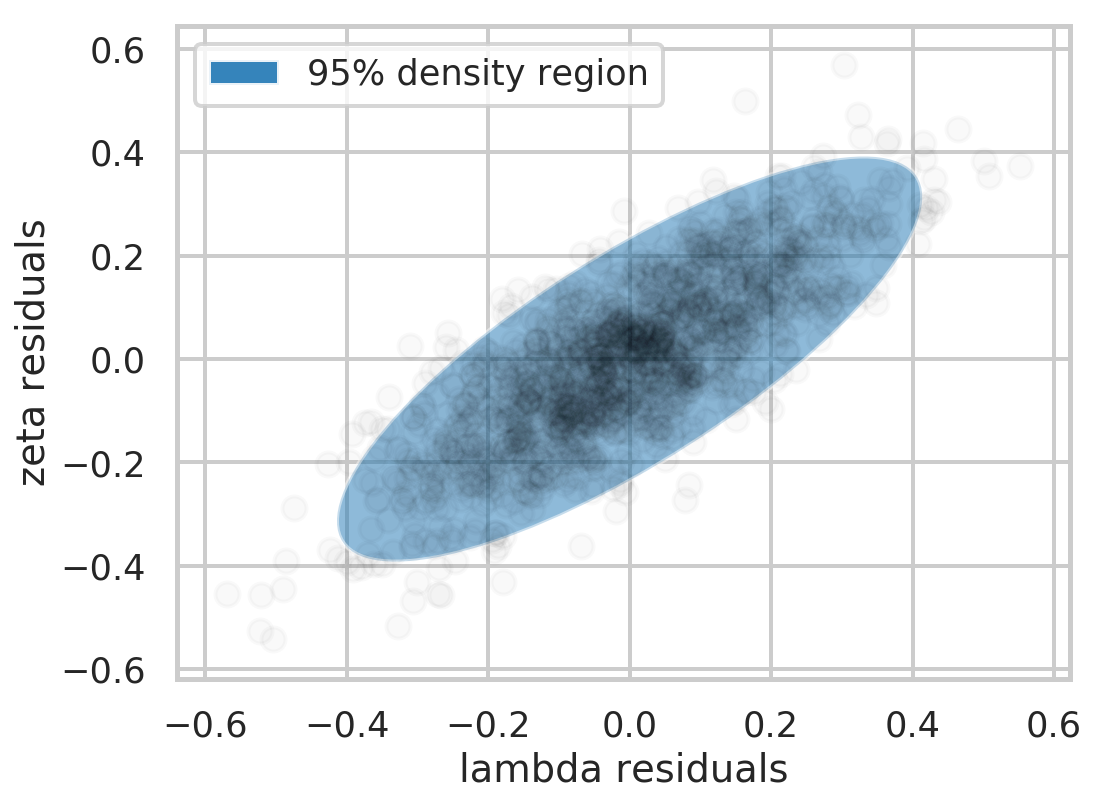

In [94]:
from matplotlib.patches import Ellipse

var, U = np.linalg.eig(Sigma_actual)
angle = 180.0 / np.pi * np.arccos(np.abs(U[0, 0]))

fig, ax = plt.subplots(figsize=(8, 6))

blue, _, red = sns.color_palette()[:3]

e = Ellipse(mu_actual, 2 * np.sqrt(5.991 * var[0]), 2 * np.sqrt(5.991 * var[1]), angle=angle)
e.set_alpha(0.5)
e.set_facecolor(blue)
e.set_zorder(10)
ax.add_artist(e)

ax.scatter(Res[:, 0], Res[:, 1], c="k", alpha=0.025, zorder=11)

rect = plt.Rectangle((0, 0), 1, 1, fc=blue, alpha=0.9)
ax.legend([rect], ["95% density region"], loc=2);
ax.set_xlabel('lambda residuals')
ax.set_ylabel('zeta residuals')

In [95]:
Xtrue = np.vstack([ln_lambda_true[cut],ln_zeta_true[cut]]).T
np.exp(Xtrue)

array([[ 82.16954964,   5.8001671 ],
       [ 87.98687785,   6.43208034],
       [ 71.3740142 ,   4.71598048],
       ...,
       [154.72633057,  15.02160833],
       [ 75.95846843,   5.16343666],
       [ 97.83551349,   7.55843076]])

In [96]:
Xobs = Xtrue+Res

In [97]:
ln_zeta = Xobs[:,1]
ln_lambda = Xobs[:,0]

In [98]:
out = dict()
out['z'] = zsims[cut]
out['M'] = msims[cut]
out['lambda'] = np.exp(ln_lambda)
out['zeta'] = np.exp(ln_zeta)
out['chisi'] = np.sqrt(np.exp(ln_zeta)**2+3)
out['lambda_true'] = np.exp(ln_lambda_true[cut])
out['zeta_true'] = np.exp(ln_zeta_true[cut])
out['res_lambda'] = out['lambda']-out['lambda_true']
out['res_zeta'] = out['zeta']-out['zeta_true']

df = pd.DataFrame(out, columns = ['z', 'M', 'lambda', 'chisi', 'zeta', 'lambda_true', 'zeta_true', 'res_lambda', 'res_zeta'])

In [99]:
## apply thresholds 

df0 = df.copy()
chisi = df0['chisi'].to_numpy()
Lambda = df0['lambda'].to_numpy()
zetacut = (Lambda>5.)& (chisi>4.5)
df = df0.loc[zetacut].copy()

display(df.describe())

,z,M,lambda,chisi,zeta,lambda_true,zeta_true,res_lambda,res_zeta
count,1417.000000,1.417000e+03,1417.000000,1417.000000,1417.000000,1417.000000,1417.000000,1417.000000,1417.000000
mean,0.359647,4.029788e+14,111.693536,9.971491,9.769626,109.557951,9.578736,2.135585,0.190890
std,0.214305,1.798863e+14,54.628509,7.845763,7.908333,49.308842,7.498565,21.440777,2.101658
min,0.100076,2.515537e+14,50.943778,4.502884,4.156437,65.196694,4.093243,-96.543506,-14.720056
25%,0.186771,2.908441e+14,78.589332,5.737960,5.470300,78.677809,5.463510,-9.501203,-0.651137
50%,0.306770,3.370168e+14,93.860353,7.188957,6.977185,91.479891,6.817412,0.496485,0.092701
75%,0.484090,4.467995e+14,124.907874,10.867164,10.728246,121.833092,10.537737,11.837170,0.879339
max,1.264496,1.556971e+15,519.996505,96.916977,96.901498,425.506651,68.874792,152.543733,28.824248


In [100]:
f=lambda x,a,b: a*x + b
def plot_linear_fit(x,y):
    fit=curve_fit(f, x, y)
    xsmooth=np.linspace(x.min(), x.max(), 1000)
    label_coefs = 'slope = {:.5f} \nintercept = {:.5f}'.format(*fit[0])
    plt.plot(xsmooth,f(xsmooth,*fit[0]),'r-',linewidth=3,label=label_coefs)

Text(0.5,1,'With $\\zeta$  Threshold')

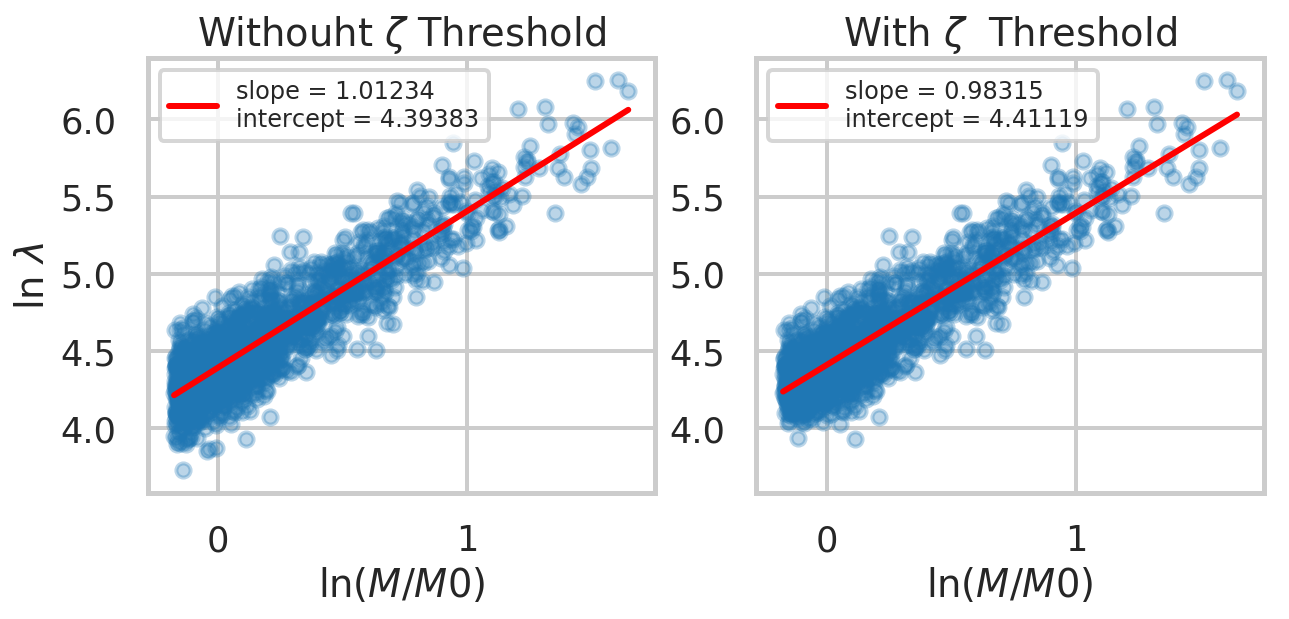

In [101]:
# without threshold
x = np.log(df0['M'].to_numpy()/M0)
y = np.log(df0['lambda'].to_numpy())

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.scatter(x,y,s=50,alpha=0.3)
plot_linear_fit(x,y)
plt.ylabel(r'ln $\lambda$')
plt.xlabel(r'ln$(M/M0)$')
plt.legend(fontsize=12)
plt.title(r'Withouht $\zeta$ Threshold')
xmin, xmax, ymin, ymax = plt.axis()

# with threshold
x = np.log(df['M'].to_numpy()/M0)
y = np.log(df['lambda'].to_numpy())

plt.subplot(1, 2, 2)
plt.scatter(x,y,s=50,alpha=0.3)
plot_linear_fit(x,y)

plt.xlabel(r'ln$(M/M0)$')
plt.legend(fontsize=12)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.title(r'With $\zeta$  Threshold')

Text(0.5,1,'With $\\zeta$  Threshold')

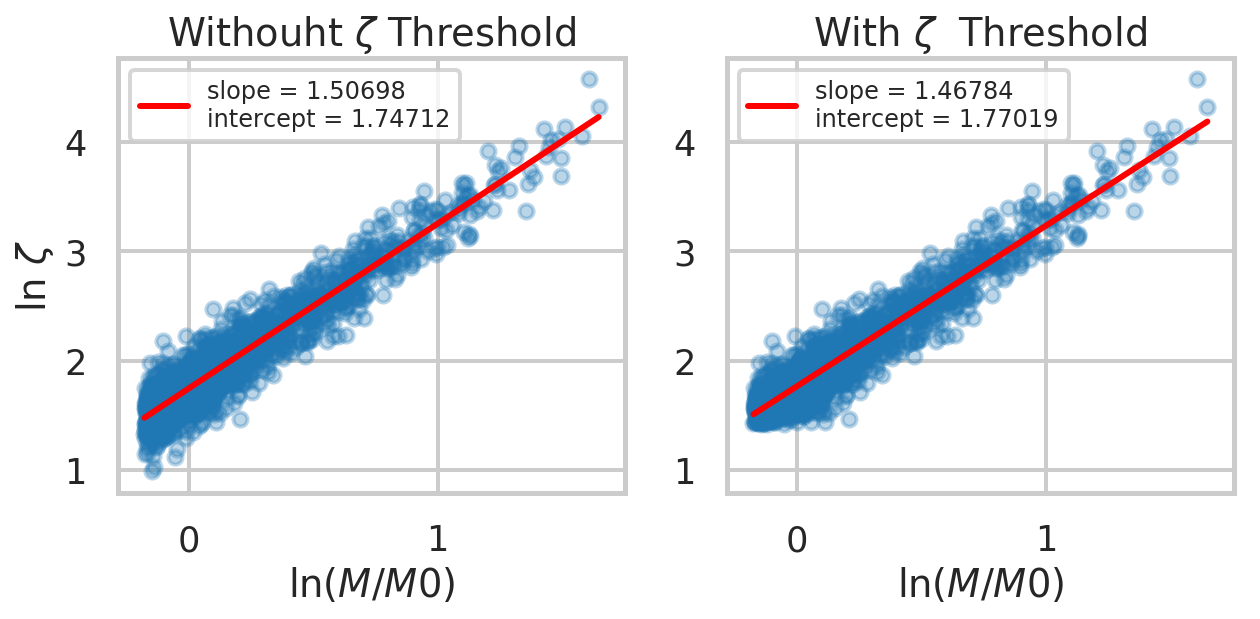

In [102]:
# without threshold
x = np.log(df0['M'].to_numpy()/M0)
y = np.log(df0['zeta'].to_numpy())

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.scatter(x,y,s=50,alpha=0.3)
plot_linear_fit(x,y)
plt.ylabel(r'ln $\zeta$')
plt.xlabel(r'ln$(M/M0)$')
plt.legend(fontsize=12)
plt.title(r'Withouht $\zeta$ Threshold')
xmin, xmax, ymin, ymax = plt.axis()

# with threshold
x = np.log(df['M'].to_numpy()/M0)
y = np.log(df['zeta'].to_numpy())

plt.subplot(1, 2, 2)
plt.scatter(x,y,s=50,alpha=0.3)
plot_linear_fit(x,y)

plt.xlabel(r'ln$(M/M0)$')
plt.legend(fontsize=12)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.title(r'With $\zeta$  Threshold')

Text(0.5,1,'With $\\zeta$  Threshold')

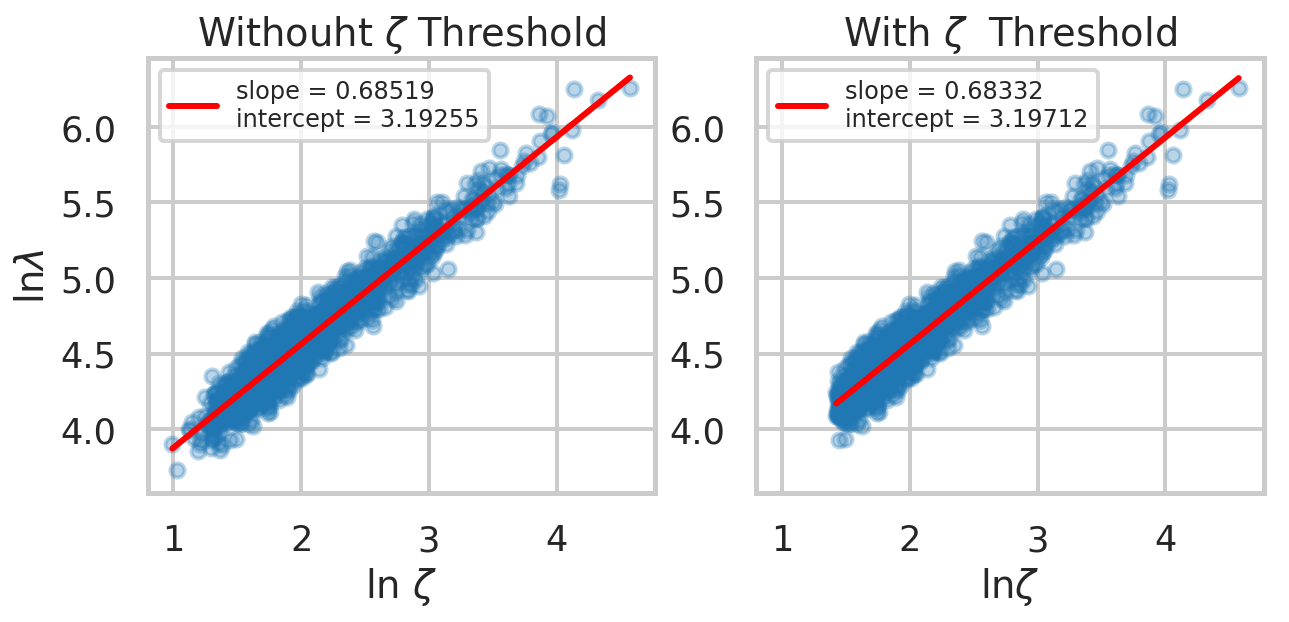

In [103]:
# without threshold
x = np.log(df0['zeta'].to_numpy())
y = np.log(df0['lambda'].to_numpy())

plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.scatter(x,y,s=50,alpha=0.3)
plot_linear_fit(x,y)
plt.xlabel(r'ln $\zeta$')
plt.ylabel(r'ln$\lambda$')
plt.legend(fontsize=12)
plt.title(r'Withouht $\zeta$ Threshold')
xmin, xmax, ymin, ymax = plt.axis()

# with threshold
x = np.log(df['zeta'].to_numpy())
y = np.log(df['lambda'].to_numpy())

plt.subplot(1, 2, 2)
plt.scatter(x,y,s=50,alpha=0.3)
plot_linear_fit(x,y)

plt.xlabel(r'ln$\zeta$')
plt.legend(fontsize=12)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.title(r'With $\zeta$  Threshold')

Text(0.5,0,'$\\lambda$')

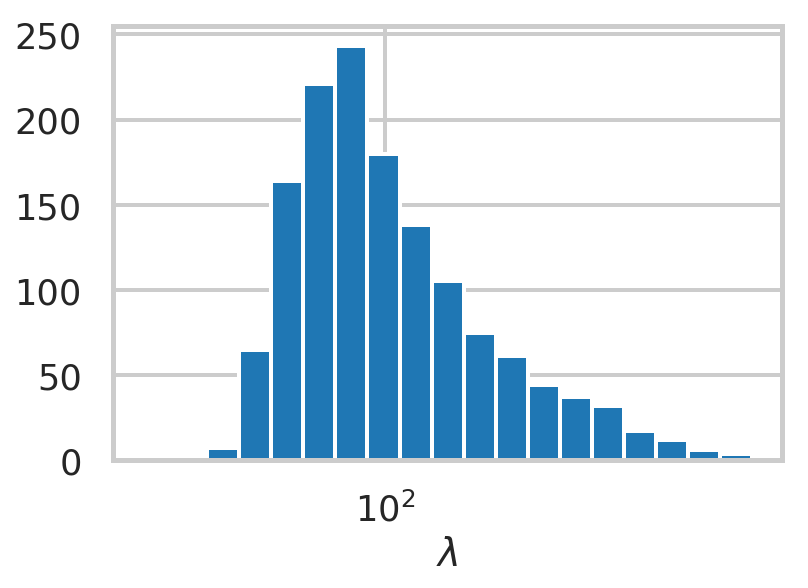

In [104]:
plt.figure(figsize=(6,4))
# plt.subplot(1, 2, 1)
plt.hist(df['lambda'],bins=np.logspace(np.log10(40),np.log10(400),20))
plt.xscale('log')
plt.xlabel(r'$\lambda$')

In [105]:
df.corr()

,z,M,lambda,chisi,zeta,lambda_true,zeta_true,res_lambda,res_zeta
z,1.000000,-0.161570,-0.078832,-0.086519,-0.086400,-0.090954,-0.089238,0.008320,-0.006718
M,-0.161570,1.000000,0.916576,0.947624,0.948492,0.997131,0.987701,0.042153,0.045037
lambda,-0.078832,0.916576,1.000000,0.955779,0.956683,0.919922,0.913493,0.432271,0.340629
chisi,-0.086519,0.947624,0.955779,1.000000,0.999979,0.950852,0.964038,0.248469,0.323204
zeta,-0.086400,0.948492,0.956683,0.999979,1.000000,0.951730,0.964174,0.248753,0.322799
lambda_true,-0.090954,0.997131,0.919922,0.950852,0.951730,1.000000,0.990653,0.044080,0.046689
zeta_true,-0.089238,0.987701,0.913493,0.964038,0.964174,0.990653,1.000000,0.049195,0.060164
res_lambda,0.008320,0.042153,0.432271,0.248469,0.248753,0.044080,0.049195,1.000000,0.760509
res_zeta,-0.006718,0.045037,0.340629,0.323204,0.322799,0.046689,0.060164,0.760509,1.000000


In [106]:
df0.corr()

,z,M,lambda,chisi,zeta,lambda_true,zeta_true,res_lambda,res_zeta
z,1.000000,-0.142358,-0.058895,-0.070318,-0.069857,-0.071981,-0.073447,0.014324,-0.001863
M,-0.142358,1.000000,0.918239,0.949019,0.949897,0.997160,0.987695,0.064818,0.064739
lambda,-0.058895,0.918239,1.000000,0.956046,0.957118,0.921670,0.913731,0.448943,0.356640
chisi,-0.070318,0.949019,0.956046,1.000000,0.999972,0.952122,0.964660,0.265773,0.336782
zeta,-0.069857,0.949897,0.957118,0.999972,1.000000,0.953026,0.964724,0.266447,0.336655
lambda_true,-0.071981,0.997160,0.921670,0.952122,0.953026,1.000000,0.990473,0.067098,0.066656
zeta_true,-0.073447,0.987695,0.913731,0.964660,0.964724,0.990473,1.000000,0.068626,0.076885
res_lambda,0.014324,0.064818,0.448943,0.265773,0.266447,0.067098,0.068626,1.000000,0.763644
res_zeta,-0.001863,0.064739,0.356640,0.336782,0.336655,0.066656,0.076885,0.763644,1.000000


In [107]:
df0.to_csv(r'fake_data_Jul4.csv', index=False)

In [108]:
len(df0)

1500